In [5]:
#import needed libraries
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     /common/home/jsp202/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#read the file
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
#df.head(n = 5)

#name the columns
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
#df.head(n = 5)

df = df.drop(['id', 'date', 'query', 'user_id'], axis = 1)
df.head(n=5)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
def sentiment_from_num(num):
    if num == 0:
        return 'Negative'
    else:
        return 'Positive'

In [8]:
#change 0 and 4 to Negative and Positive

lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

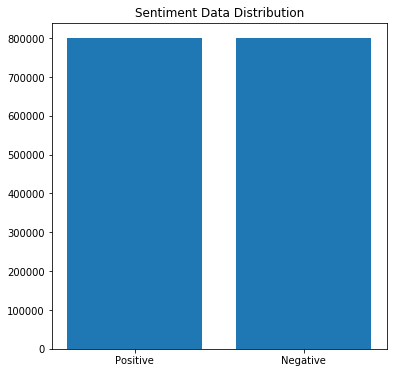

In [9]:
#plot positive vs negative tweets in dataset
val_count = df.sentiment.value_counts()

plt.figure(figsize=(6,6))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [10]:
#need to clean the tweets using NLTK

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

In [13]:
TRAIN_SIZE = 0.75
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [14]:
#split data into training and testing
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7)
print("Training size:", len(train_data))
print("Testing size", len(test_data))

train_data.head(n=5)


Training size: 1200000
Testing size 400000


,sentiment,text
386974,Negative,train back london
421751,Negative,yesterday embarrassing feel pity
301839,Negative,red rings death xbox 360 towel trick windows o...
7356,Negative,reeling news 11 10 year old charged attempted ...
1102338,Positive,love way official selena gomez twitter


In [15]:
#tokenization

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Using TensorFlow backend.


Vocabulary Size : 278805


In [16]:
#add padding to make them all same sequence length

from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1200000, 30)
Testing X Shape: (400000, 30)


In [17]:
labels = train_data.sentiment.unique().tolist()

In [18]:
#label encoding

encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1200000, 1)
y_test shape: (400000, 1)


In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-12-05 17:21:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-05 17:21:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-05 17:21:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [28]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'best_model.hdf5'

In [29]:
#GloVe Embedding

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [30]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [31]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [32]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#embedding layer
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
#Conv1D layer
x = Conv1D(64, 5, activation='relu')(x)
#LSTM layer
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
#Dense layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
#Dense layer
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [34]:
#use Adam - optimized gradient descent algo

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [35]:
#train

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Train on 1200000 samples, validate on 400000 samples
Epoch 1/10
1200000/1200000 [==============================] - 263s 219us/sample - loss: 0.5231 - acc: 0.7365 - val_loss: 0.4847 - val_acc: 0.7645
Epoch 2/10
1200000/1200000 [==============================] - 220s 183us/sample - loss: 0.4899 - acc: 0.7609 - val_loss: 0.4719 - val_acc: 0.7719
Epoch 3/10
1200000/1200000 [==============================] - 216s 180us/sample - loss: 0.4797 - acc: 0.7674 - val_loss: 0.4676 - val_acc: 0.7741
Epoch 4/10
1200000/1200000 [==============================] - 220s 183us/sample - loss: 0.4736 - acc: 0.7714 - val_loss: 0.4643 - val_acc: 0.7773
Epoch 5/10
1200000/1200000 [==============================] - 217s 181us/sample - loss: 0.4687 - acc: 0.7747 - val_loss: 0.4633 - val_acc: 0.7781
Epoch 6/10
1200000/1200000 [==============================] - 218s 182us/sample - loss: 0.4650 - acc: 0.7771 - val_loss: 0.4617 - val_acc: 0.7791
Epoch 7/10
1200000/1200000 [==============================] - 218s 182u

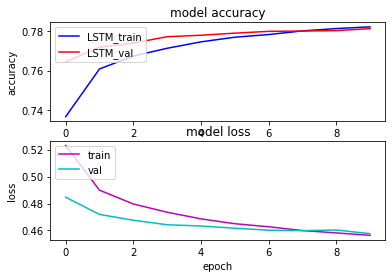

In [36]:
#graph training accuracy and validation accuracy

s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [37]:
#test the model on testing data

def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

400000/400000 [==============================] - 17s 43us/sample


In [38]:
#confusion matrix

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

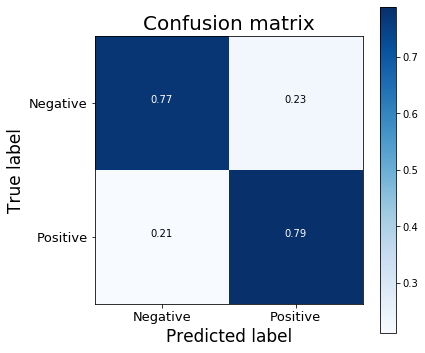

In [39]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [40]:
#classification report

print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    201003
    Positive       0.78      0.79      0.78    198997

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000

